# **APLICAÇÃO DAS REDES FULLY CONNECTED PARA CLASSIFICAÇÃO MULTICLASSE**

Nesse material, estarei focado em mostrar como construir uma rede que pode receber uma imagem de um dígito manuscrito como entrada e identificar qual dos dez dígitos (0 a 9) a imagem representa e apresentar essa informação em suas saídas.

## **DATASET A SER UTILIZADO**

O dataset que será utilizado nesse exemplo é o **MNIST** (*Modified National Institute of Standards and Technology*), que contém imagens de digitos manuscritos.

**SOBRE O DATASET**

O *MNIST* contém 70.000 imagens, cada uma com sua *label* indicando o dígito que ela representa, em tons de cinza de dígitos manuscritos (de 0 a 9), divididas em 60.000 exemplos de treinamento e 10.000 exemplos de teste (que pode ser alterado). Cada imagem tem 28 pixels de altura e 28 pixels de largura, totalizando 784 (28x28) pixels. As imagens já estão em apenas um canal, ou seja, cada pixel tem um único valor de pixel associado a ele, indicando a claridade ou escuridão desse pixel, com números mais altos significando mais escuro. Este valor de pixel é um número inteiro entre 0 e 255.

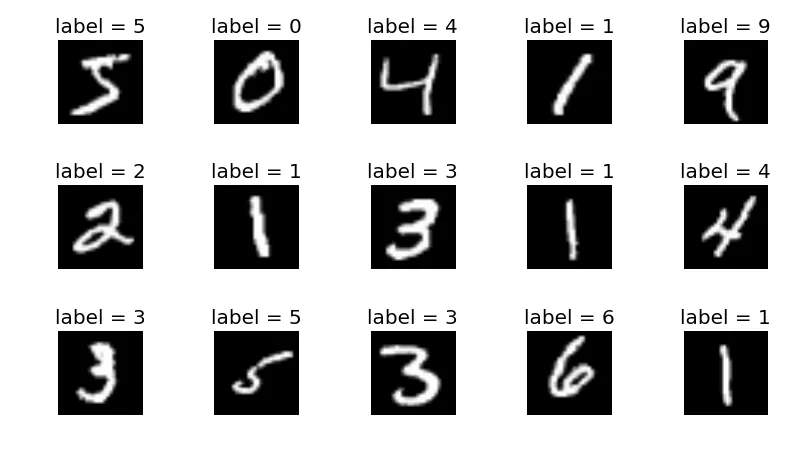 *Exemplo das imagens e dos rótulos que estão presentes no dataset.*

### **EXPLORANDO O DATASET**

In [53]:
import idx2numpy

TRAIN_IMAGE_FILENAME = r'C:\Users\João Pedro\Documents\LDL\data\mnist\train-images-idx3-ubyte\train-images-idx3-ubyte'
TRAIN_LABEL_FILENAME = r'C:\Users\João Pedro\Documents\LDL\data\mnist\train-labels-idx1-ubyte\train-labels-idx1-ubyte'
TEST_IMAGE_FILENAME = r'C:\Users\João Pedro\Documents\LDL\data\mnist\t10k-images-idx3-ubyte\t10k-images-idx3-ubyte'
TEST_LABEL_FILENAME = r'C:\Users\João Pedro\Documents\LDL\data\mnist\t10k-labels-idx1-ubyte\t10k-labels-idx1-ubyte'

#Leitura dos arquivos
train_images = idx2numpy.convert_from_file(TRAIN_IMAGE_FILENAME)
train_labels = idx2numpy.convert_from_file(TRAIN_LABEL_FILENAME)
test_images = idx2numpy.convert_from_file(TEST_IMAGE_FILENAME)
test_labels = idx2numpy.convert_from_file(TEST_LABEL_FILENAME)

#Printar as dimensões dos dados
print('Dimensões de train_images: ', train_images.shape)
print('Dimensões de train_labels: ', train_labels.shape)
print('Dimensões de test_images: ', test_images.shape)
print('Dimensões de test_images: ', test_labels.shape)

Dimensões de train_images:  (60000, 28, 28)
Dimensões de train_labels:  (60000,)
Dimensões de test_images:  (10000, 28, 28)
Dimensões de test_images:  (10000,)


Os *arrays* das imagens são **3D**. A primeira dimensão representa a imagem selecionada e as outras duas representam os valores dos 28x28 pixels, que são números inteiros de 0 a 255.

Já os *arrays* das *labels* são **1D**. Onde cada elemento corresponde a uma das 60.000 imagens (ou 10.000).

In [54]:
#Printando a label do primeiro exemplo de treinamento
print('Label do primeiro exemplo de treinamento: ', train_labels[0])
print('---Início do padrão do primeiro exemplo de treinamento---')
for line in train_images[0]:
    for num in line:
        if num > 0:
            print('*', end = ' ')
        else:
            print(' ', end = ' ')
    print('')
print('---Fim do padrão do primeiro exemplo de treinamento---')

Label do primeiro exemplo de treinamento:  5
---Início do padrão do primeiro exemplo de treinamento---
                                                        
                                                        
                                                        
                                                        
                                                        
                        * * * * * * * * * * * *         
                * * * * * * * * * * * * * * * *         
              * * * * * * * * * * * * * * * *           
              * * * * * * * * * * *                     
                * * * * * * *   * *                     
                  * * * * *                             
                      * * * *                           
                      * * * *                           
                        * * * * * *                     
                          * * * * * *                   
                            * * * * * *   

**GENERALIZAÇÃO, DIVISÃO DE DATASETS E OVERFITTING**

O que buscamos ao treinar modelos de *Machine Learning* ou de *Deep Learning* é a capacidade de generalizar que esses modelos podem obter, ou seja, que eles consigam "aprender" os padrões nos dados que foi treinado e replicar esse conhecimento para dados nunca vistos e não que eles apenas decorem o conjunto de dados que temos. Visando isso, fazemos algumas divisões em nossos *datasets*, dividindo-os em um conjunto de treinamento, que é usado para treinar o modelo, e um conjunto de teste, que é usado para avaliar/mensurar quão bem o modelo treinado generaliza.

A partir dessa divisão, podemos monitorar a *loss* do treinamento e a do teste para ver se o modelo está generalizando ou apenas decorando. Geralmente, a *loss* de treinamento diminui e se estabiliza. Já a *loss* de teste começa alta, vai diminuindo e depois começa a subir (quase um formato de "U"). Se a *loss* de teste começa a aumentar enquanto a de treinamento continua a diminuir é um sinal que o modelo está *overfittando*, sofrendo um sobreajuste com relação aos dados de treinamento.

Uma técnica eficaz para tentar evitar o *overfitting* é aumentar o tamanho do *dataset*. Um outro método, conhecido como *early stopping* (parada antecipada), é simplesmente monitorar a *loss* de teste durante o treinamento e parar quando ela começar a subir. Como a *loss* pode variar bastante, uma abordagem conhecida é ir salvando *checkpoints* do modelo em intervalos determinados e, ao final, selecionar o modelo que teve a menor *loss* de teste.

## **ARQUITETURA A SER UTILIZADA PARA A CLASSIFICAÇÃO**

Como cada imagem contém 784 pixels (28x28), a camada de entrada da rede terá 784 neurônios de entrada. A rede terá uma camada oculta, que escolhi arbitrariamente que tivesse 25 neurônios, e a camada de saída com 10 neurônios, um para cada dígito que quero reconhecer. Usarei a *tanh* como função de ativação para os neurônios da camada oculta e a *sigmoide* para os da camada de saída. A rede será **totalmente conectada** (*fully connected*), ou seja, cada neurônio em uma camada estará conectado com todos da camada seguinte. Já que essa rede possui apenas uma *hidden layer* (camada oculta), ela  não pode ser considerada uma rede profunda, já que são necessárias pelo menos duas *hidden layers* para chamar de rede profunda.

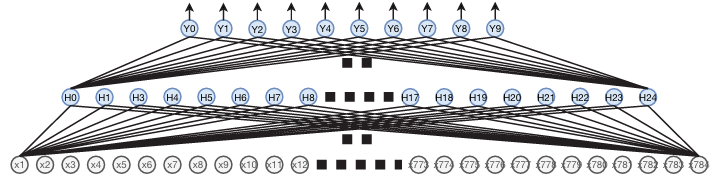 *Esquema da arquitetura da nossa rede para classificação de dígitos*

## **HANDS ON: PARTE PRÁTICA**

### Inicialização

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import idx2numpy

np.random.seed(7)
LEARNING_RATE = 0.01
EPOCHS = 20
TRAIN_IMAGE_FILENAME = r'C:\Users\João Pedro\Documents\LDL\data\mnist\train-images-idx3-ubyte\train-images-idx3-ubyte'
TRAIN_LABEL_FILENAME = r'C:\Users\João Pedro\Documents\LDL\data\mnist\train-labels-idx1-ubyte\train-labels-idx1-ubyte'
TEST_IMAGE_FILENAME = r'C:\Users\João Pedro\Documents\LDL\data\mnist\t10k-images-idx3-ubyte\t10k-images-idx3-ubyte'
TEST_LABEL_FILENAME = r'C:\Users\João Pedro\Documents\LDL\data\mnist\t10k-labels-idx1-ubyte\t10k-labels-idx1-ubyte'

### Obtendo os dados de teste e treino dos arquivos

In [56]:
#Função para ler os dados do MNIST
def read_mnist():
    train_images = idx2numpy.convert_from_file(
        TRAIN_IMAGE_FILENAME)
    train_labels = idx2numpy.convert_from_file(
        TRAIN_LABEL_FILENAME)
    test_images = idx2numpy.convert_from_file(
        TEST_IMAGE_FILENAME)
    test_labels = idx2numpy.convert_from_file(
    TEST_LABEL_FILENAME)

    #Normalização dos dados
    x_train = train_images.reshape(60000, 784)
    mean = np.mean(x_train)
    stddev = np.std(x_train)
    x_train = (x_train - mean) / stddev
    x_test = test_images.reshape(10000, 784)
    x_test = (x_test - mean) / stddev
 
    #Transformando as labels em *one-hot encoding*
    y_train = np.zeros((60000, 10))
    y_test = np.zeros((10000, 10))
    for i, y in enumerate(train_labels):
        y_train[i][y] = 1
    for i, y in enumerate(test_labels):
        y_test[i][y] = 1
    return x_train, y_train, x_test, y_test

#Lendo os dados dos arquivos
x_train, y_train, x_test, y_test = read_mnist()
index_list = list(range(len(x_train))) #Lista de índices para embaralhar os dados

Nessa parte de processamento dos dados, fiz um *reshape* das imagens juntando as duas dimensões que representavam os pixels em uma dimensão só, a partir disso, os *arrays* das imagens são **2D** e não **3D**.

Realizei a padronização dos dados, escalonando os valores dos pixels e os centralizando em torno de 0. Para isso, calculei a média e o desvio padrão de todos os valores de treinamento. Após isso, padronizei os dados subtraindo a média de cada valor de pixel e dividindo pelo desvio padrão. Após isso, a nova média de todos os pixels será 0. Com esse tratamento dos dados, os valores de pixels que eu possuía variava de 0 a 255, agora é um conjunto de pontos flutuantes centrados e próximos de 0.

Outra modificação feita foi codificar as nossas *labels* em ***one-hot***. Para isso, criamos um *array* de 10 posições, cada uma indicando o número correspondente, e a posição que possuir o valor 1 define a *label* do nosso exemplo.

### Inicialização e instanciação de todos os neurônios

In [57]:
def layer_w(neuron_count, input_count):
    weights = np.zeros((neuron_count, input_count+1))
    for i in range(neuron_count):
        for j in range(1, (input_count+1)):
            weights[i][j] = np.random.uniform(-0.1, 0.1)
    return weights

#Declarando as matrizes e os vetores que representam os neurônios
hidden_layer_w = layer_w(25, 784)
hidden_layer_y = np.zeros(25)
hidden_layer_error = np.zeros(25)

output_layer_w = layer_w(10, 25)
output_layer_y = np.zeros(10)
output_layer_error = np.zeros(10)

### Funções para relatar o progresso e visualizar o aprendizado

In [58]:
chart_x = []
chart_y_train = []
chart_y_test = []

def show_learning(epoch_no, train_acc, test_acc):
    global chart_x
    global chart_y_train
    global chart_y_test
    print('epoch no:', epoch_no, ', train_acc: ', '%6.4f' % train_acc, ', test_acc: ', '%6.4f' % test_acc)
    chart_x.append(epoch_no + 1)
    chart_y_train.append(1.0 - train_acc)
    chart_y_test.append(1.0 - test_acc)

def plot_learning():
    plt.plot(chart_x, chart_y_train, 'r-', label='training error')
    plt.plot(chart_x, chart_y_test, 'b-', label='test error')
    plt.axis([0, len(chart_x), 0.0, 1.0])
    plt.xlabel('training epochs')
    plt.ylabel('error')
    plt.legend()
    plt.show()

### Funções das passagens (*forward* e *backward*) e do ajuste dos pesos

In [59]:
def forward_pass(x):
    global hidden_layer_y
    global output_layer_y
    #Função de ativação para a camada oculta
    for i, w in enumerate(hidden_layer_w):
        z = np.dot(w, x)
        hidden_layer_y[i] = np.tanh(z)
    hidden_output_array = np.concatenate((np.array([1.0]), hidden_layer_y))
    #Função de ativação para a camada de saída
    for i, w in enumerate(output_layer_w):
        z = np.dot(w, hidden_output_array)
        output_layer_y[i] = 1.0 / (1.0 + np.exp(-z))

def backward_pass(y_truth):
    global hidden_layer_error
    global output_layer_error
    #Retropropaga o erro para cada neurônio de saída
    # e cria um array com todos os erros dos neurônios de saída.
    for i, y in enumerate(output_layer_y):
        error_prime = -(y_truth[i] - y) #Derivada da loss
        derivative = y * (1.0 - y) #Derivada da função logística
        output_layer_error[i] = error_prime * derivative

    for i, y in enumerate(hidden_layer_y):
        #Cria um array com os pesos que conectam a saída
        # do neurônio oculto i aos neurônios da camada de saída.
        error_weights = []
        for w in output_layer_w:
            error_weights.append(w[i+1])
        error_weight_array = np.array(error_weights)
        #Retropropaga o erro para o neurônio oculto.
        derivative = 1.0 - y**2 #Derivada da função tangente hiperbólica
        weighted_error = np.dot(error_weight_array, output_layer_error)
        hidden_layer_error[i] = weighted_error * derivative


def adjust_weights(x):
    global output_layer_w
    global hidden_layer_w
    for i, error in enumerate(hidden_layer_error):
        hidden_layer_w[i] -= (x * LEARNING_RATE * error) #Atualização dos pesos
    hidden_output_array = np.concatenate((np.array([1.0]), hidden_layer_y))
    for i, error in enumerate(output_layer_error):
        output_layer_w[i] -= (hidden_output_array * LEARNING_RATE * error) #Atualização dos pesos
    

### *Loop* de treinamento da rede

epoch no: 0 , train_acc:  0.8563 , test_acc:  0.9157
epoch no: 1 , train_acc:  0.9203 , test_acc:  0.9240
epoch no: 2 , train_acc:  0.9276 , test_acc:  0.9271
epoch no: 3 , train_acc:  0.9324 , test_acc:  0.9298
epoch no: 4 , train_acc:  0.9350 , test_acc:  0.9323
epoch no: 5 , train_acc:  0.9379 , test_acc:  0.9346
epoch no: 6 , train_acc:  0.9403 , test_acc:  0.9369
epoch no: 7 , train_acc:  0.9423 , test_acc:  0.9365
epoch no: 8 , train_acc:  0.9441 , test_acc:  0.9315
epoch no: 9 , train_acc:  0.9447 , test_acc:  0.9367
epoch no: 10 , train_acc:  0.9464 , test_acc:  0.9365
epoch no: 11 , train_acc:  0.9475 , test_acc:  0.9380
epoch no: 12 , train_acc:  0.9485 , test_acc:  0.9359
epoch no: 13 , train_acc:  0.9493 , test_acc:  0.9347
epoch no: 14 , train_acc:  0.9505 , test_acc:  0.9387
epoch no: 15 , train_acc:  0.9502 , test_acc:  0.9363
epoch no: 16 , train_acc:  0.9518 , test_acc:  0.9372
epoch no: 17 , train_acc:  0.9526 , test_acc:  0.9389
epoch no: 18 , train_acc:  0.9529 , te

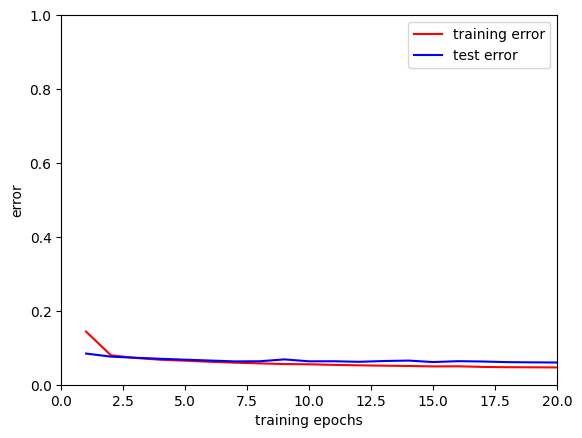

In [60]:
for i in range(EPOCHS): #Definição do número de épocas/iterações
    np.random.shuffle(index_list) #Aleatoriza a ordem dos dados
    correct_training_results = 0
    for j in index_list: #Treina em todos os exemplos
        x = np.concatenate((np.array([1.0]), x_train[j]))
        forward_pass(x)
        if output_layer_y.argmax() == y_train[j].argmax():
            correct_training_results += 1
        backward_pass(y_train[j])
        adjust_weights(x)

    correct_test_results = 0
    for j in range(len(x_test)): #Avalia a rede
        x = np.concatenate((np.array([1.0]), x_test[j]))
        forward_pass(x)
        if output_layer_y.argmax() == y_test[j].argmax():
            correct_test_results += 1
    #Mostra o progresso do treinamento
    show_learning(i, correct_training_results/len(x_train),
                  correct_test_results/len(x_test))
plot_learning() #Plotar o gráfico de aprendizado

Uma época (*epoch*) é definida como uma iteração completa por todos os dados de treinamento.

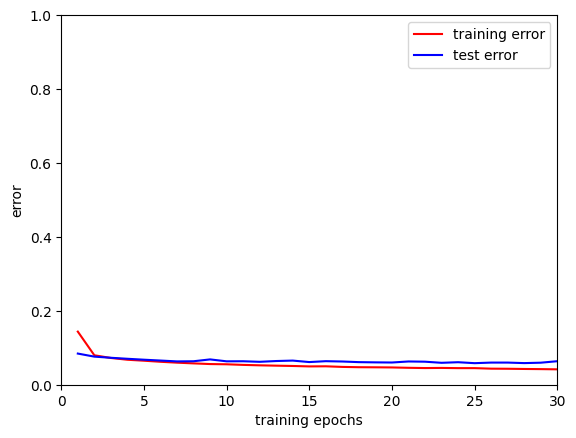 *Imagem do treinamento para 30 epochs, dá para notar que a última epoch tem uma tendência de subir a loss de teste, o que pode indicar um princípio de overfitting*

Em comparação com o de 30 *epochs* o gráfico do treino com 20 *epochs* não demonstra um aumento na *loss* de teste, o que indica que não houve overfitting.